# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
import glob, ntpath, os
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

DATA_FOLDER = 'data/'

In [2]:
# Custom functions

def read_csvs(dir, regex="*.csv", has_header=True, append_origin=True):
    return read_data_files(dir, regex, pd.read_csv, has_header, append_origin)

def read_excels(dir, regex="*.xls", has_header=True, append_origin=True):
    return read_data_files(dir, regex, pd.read_excel, has_header, append_origin)
    
def read_data_files(dir, regex, func, has_header, append_origin):
    all_files = glob.glob(os.path.join(dir, regex))
    dfs = []
    for file in all_files:
        df = func(file, header=0 if has_header else None)
        if append_origin:
            df['File'] = path_leaf(file)
        dfs.append(df)
    return pd.concat(dfs)

def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [3]:
# Write your answer here
countries = dict.fromkeys(['guinea', 'liberia', 'sl'])

for country in countries:
    FULL_PATH = DATA_FOLDER + "ebola/" + country + "_data/"
    for csv_file in os.listdir(FULL_PATH):
        if countries[country] is None:
            countries[country] = pd.read_csv(FULL_PATH + csv_file, sep=',')
        else:
            nextFrame = pd.read_csv(FULL_PATH + csv_file, sep=',')
            countries[country] = pd.concat([countries[country], nextFrame], axis=0)
            

We only consider confirmed cases as legitimate cases.

## Solution Task 1

Some initial thoughts:
- We will try to keep everything we know about the data that will help us sanitize it in a data structure.
- Most of the differences between the datasets are between the different countries, so we should store the attributes per country.
- For 'new cases' we will only consider confirmed cases, which fields are read for which specific country is stored in the 'case' variable of 'dt_info' below.
- For 'deaths' we will only consider confirmed deaths, the fields considered for this are stored in the 'deaths' attribute of the 'dt_info' variable below.
- Some data inspection shows that we have to deal with the following problems
    * There are some NaN values in the data
    * There are some dashes ('-') instead of numbers, we will just set them to zero
    * The column containing the total will be ignored for each dataset, instead we collapse the regions and sum the.
    * For the liberia data, there is likely a mistake in the data from the 4th of December until the 9th of December, where the new cases contain the numbers of the total cases. We will set those values to zero, which should be a safe assumption when looking at the previous data. 

In [4]:
# Data structure to contain all information for data parsing purposes per country
# (field names, columns to exclude, etc)
dt_info = {
    'guinea' : {
        'case' : 'New cases of confirmed',
        'deaths' : [
            'New deaths registered',
            'New deaths registered today'
        ],
        'var' : 'Description',
        'exclude' : ['Totals', 'Description'],
        'date' : 'Date'
    },
    'liberia' : {
        'case' : 'New case/s (confirmed)',
        'deaths' : [
            'Newly reported deaths'
        ],
        'var' : 'Variable',
        'exclude' : ['National', 'Variable'],
        'date' : 'Date'
    },
    'sl' : {
        'case' : 'new_confirmed',
        'deaths' : [
            'etc_new_deaths'
        ],
        'var' : 'variable',
        'exclude' : ['National', 'variable'],
        'date' : 'date'
    }
}
"""
 TODO:
    - investigate unnamed
    - check that variable columns in original data does not cause trouble
    - 
"""

cases = []
deaths = []
for country in countries:
    info = dt_info[country]
    df = countries[country]

    # parse date
    df[info['date']] = pd.to_datetime(df[info['date']])
    # set index
    df = df.set_index(info['date'])

    # sort by date
    df.sort_index(inplace=True)

    # get rid of NaN values
    df = df.fillna(0)
    # get rid of dashes
    df = df.replace('-', '')

    
    # filter out cases
    dfc = df.loc[df[info['var']] == info['case']].copy(deep=True)
    # filter out deaths
    dfd = df.loc[df[info['var']].isin(info['deaths'])].copy(deep=True)
    
    # delete non-numerics
    for column in info['exclude']:
        del dfc[column]
        del dfd[column]
        
    # convert all values to numeric
    for column in list(dfc):
        dfc[column] = pd.to_numeric(dfc[column])
        dfd[column] = pd.to_numeric(dfd[column])
        
    # collapse regions
    dfc[country] = dfc[list(dfc)].sum(axis=1)
    dfc = dfc[country]
    dfd[country] = dfd[list(dfd)].sum(axis=1)
    dfd = dfd[country]
    
    # exclude 4th to 9th december in liberia (wrong data, total instead of new cases)
    if country == 'liberia':
        dfc.loc['2014-12-04':'2014-12-09'] = 0
    # create daily average per month
    dfc = dfc.groupby(pd.TimeGrouper(freq='M')).mean()
    cases.append(dfc)
    dfd = dfd.groupby(pd.TimeGrouper(freq='M')).mean()
    deaths.append(dfd)
    

# Concat all tables
dfc = pd.concat(cases, axis=1)
dfd = pd.concat(deaths, axis=1)
# Add labels
df = pd.concat([dfc, dfd], axis=1, keys=['cases', 'deaths'])
# Change date format
df.index = df.index.strftime('%B')
df

cases                        deaths                     
            guinea   liberia         sl   guinea    liberia        sl
June           NaN  2.142857        NaN      NaN   1.857143       NaN
July           NaN  1.818182        NaN      NaN   4.272727       NaN
August     12.4000  5.444444  19.600000   3.2000  23.222222  5.550000
September  12.5625  6.166667  36.275862   3.5625  36.041667  4.344828
October     6.0000  1.240000  57.535714  15.0000  28.120000  2.071429
November       NaN  2.533333  63.238095      NaN  13.666667  0.428571
December       NaN  1.111111  32.600000      NaN   0.000000  0.000000

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [5]:
# Write your answer here

RNA_METADATA_PATH = DATA_FOLDER + 'microbiome/metadata.xls'
RNA_SEQUENCING_PATH = DATA_FOLDER + 'microbiome/'

metadata = pd.read_excel(RNA_METADATA_PATH, header=0, index_col = "BARCODE")
metadata.index.names = ['Barcode']
metadata.columns = ['Group', 'Sample origin']
metadata['Sample origin'] = metadata['Sample origin'].fillna("unknown")

microbiome = read_excels(RNA_SEQUENCING_PATH, regex="MID*.xls", has_header=False)
microbiome['File'] = list(map(lambda f: f.split(".")[0], microbiome['File'].values))
microbiome.columns = ['Name', 'Occurrence', 'Case']
microbiome['Group'] = [metadata.loc[m[2].split(".")[0]]['Group'] for m in microbiome.values]
microbiome['Sample origin'] = [metadata.loc[m[2].split(".")[0]]['Sample origin'] for m in microbiome.values]
microbiome = microbiome.set_index(['Name', 'Case'])

microbiome.head()


,,Occurrence,Group,Sample origin
Name,Case,,,
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Acidilobaceae Acidilobus",MID2,2,NEC 1,tissue
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Caldisphaeraceae Caldisphaera",MID2,14,NEC 1,tissue
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera",MID2,23,NEC 1,tissue
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Sulfophobococcus",MID2,1,NEC 1,tissue
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Thermosphaera",MID2,2,NEC 1,tissue


## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [6]:
from IPython.core.display import HTML
pd.options.mode.chained_assignment = None

HTML(filename=DATA_FOLDER+'/titanic.html')

TITANIC_DATA_PATH = DATA_FOLDER + '/titanic.xls'
titanic_original = pd.read_excel(TITANIC_DATA_PATH)

For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [7]:
# 1st point: Describe the type and the value range of each attribute. Indicate and transform the attributes 
# that can be Categorical.

titanic = titanic_original.copy()

With '.dtypes' property, we can get a sense of the types of information we are working with.

In [8]:
titanic.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

With 'describe' method we can get a sense of value ranges that we are dealing with, and infer which attributes can be treated as 'Categorical'.

In [9]:
titanic.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


The following attributes can be categorical:

* pclass
* sex (can be trasformed in a dummy variable, too: 1 if the passeger was male, 0 instead)
* age (can be trasformed in a categorical attribute - one value per decade)
* embarked 

In [10]:
# Trasforming 'pclass' to a categorical attribute.
titanic['pclass'] = titanic.pclass.astype('category')

# Trasforming 'sex' to a categorical attribute.
titanic['sex'] = titanic.sex.astype('category')

# Trasforming 'embarked' to a categorical attribute.
titanic['embarked'] = titanic.embarked.astype('category')

#trasforming age to a categorical attribute
titanic.age = pd.cut(titanic.age, [0,10, 20,30,40,50,60,70,80], labels = [1,2,3,4,5,6,7,8])[:30]

titanic.dtypes


pclass       category
survived        int64
name           object
sex          category
age          category
sibsp           int64
parch           int64
ticket         object
fare          float64
cabin          object
embarked     category
boat           object
body          float64
home.dest      object
dtype: object

We suppose that most of the passengers were placed in the 3rd class, that there were more male than female passengers and that most of the passengers are between 30 and 40 years old.

**NOTE:** Due to inconsistencies within provided data, total count of passengers taken into account within each plot varies. Only passengers who had necessary plot information present were taken into account.

/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


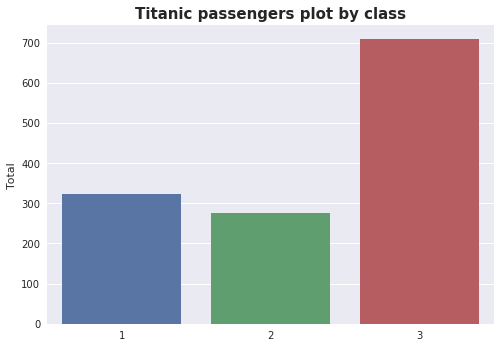

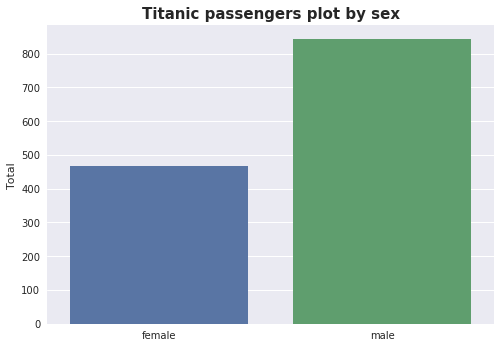

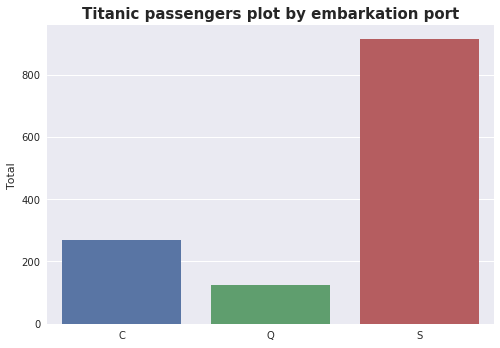

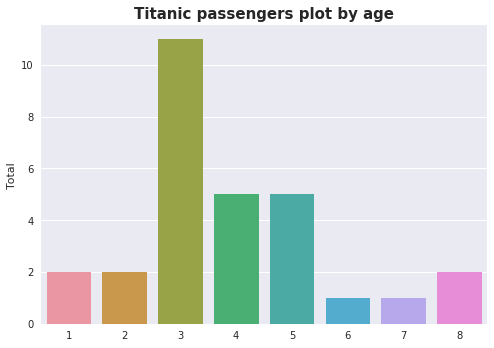

In [11]:
# 2nd task: Plot histograms for the travel class, embarkation port, sex and age attributes. For the latter one, 
# use discrete decade intervals.

def titanic_plot(y, xlbl):
    fig, ax = plt.subplots()
    ax.set_title('Titanic passengers plot by '+ xlbl , fontsize=15, fontweight='bold')
    sns.barplot(y.keys(), y, ax=ax)
    locs, labels = plt.xticks()
    plt.ylabel('Total')
    plt.show()

titanic_plot(titanic.pclass.value_counts(), 'class')
titanic_plot(titanic.sex.value_counts(),'sex')
titanic_plot(titanic.embarked.value_counts(),'embarkation port')
titanic_plot(titanic.age.value_counts(),'age')

After plotting the data, we see that all of our assumptions were correct except the one regarding age. Plot shows that most of the passengers were between 20 and 30 years old.

/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


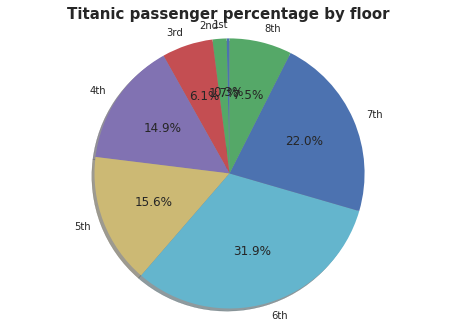

In [12]:
# 3rd task: Calculate the proportion of passengers by cabin floor. Present your results in a pie chart.

# Every letter identifies a floor, so we transform each cabin attribute to this single letter.
# We are discarding entries with cabin values that are not present.

titanic_3 = titanic_original.copy()
titanic_3['cabin'] = titanic_3['cabin'].dropna()

cabin_list = ['A','B','C','D','E','F','G','T']
for letter in cabin_list:
    titanic_3['cabin'][titanic_3['cabin'].str.contains(letter, na=False)] = letter
    
# Count the total number of known cabins.
cabins = len(titanic_3['cabin'])
# Calculate the percentage of passenger for each plan
cabins_count = titanic_3['cabin'].value_counts() 
perc = cabins_count / cabins * 100

# Plotting
labels = '1st','2nd','3rd','4th','5th','6th','7th','8th'
sizes = [perc['T'],perc['G'], perc['F'], perc['E'], perc['D'], perc['C'], perc['B'], perc['A']]
fig1, ax1 = plt.subplots()
ax1.set_title('Titanic passenger percentage by floor ', fontsize=15, fontweight='bold')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()


/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


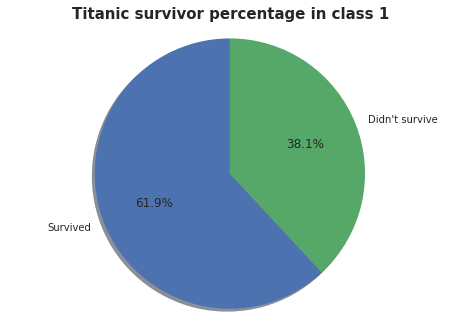

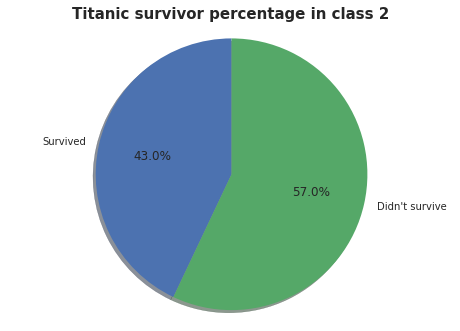

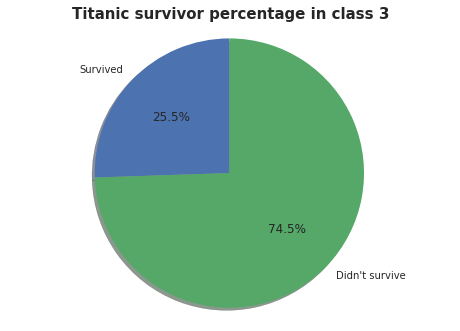

In [13]:
# 4th task: For each travel class, calculate the proportion of the passengers that survived. Present your results 
# in pie charts.

titanic_4 = titanic.copy()
titanic_4['pclass'] = titanic_4['pclass'].astype('float')

# Plot function
def titanic_pie_chart(s,ns):
    labels = 'Survived', 'Didn\'t survive'
    sizes = [s, ns]
    fig1, ax1 = plt.subplots()
    ax1.set_title('Titanic survivor percentage in class ' + repr(i) , fontsize=15, fontweight='bold')
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')  
    plt.show()

# Grouping data and calculating number of survivors per class.
x = titanic_4.groupby(titanic_4.pclass).aggregate(np.sum)
y = titanic_4.pclass.value_counts()  

# Plots
for i in range(1,4):
    s=100*x.survived.loc[i]/y[i]
    ns=100-s
    titanic_pie_chart(s,ns)

We are making an assumption that most of the survivors will be women, and our assumption is being confirmed by the plots.

/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


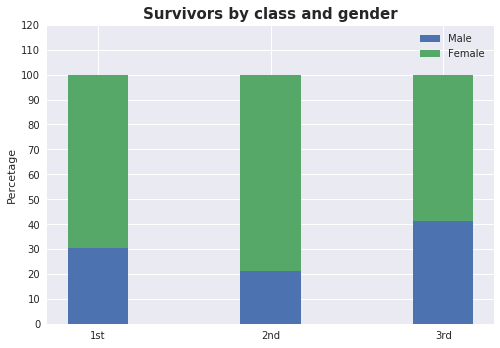

In [14]:
# 5th task: Calculate the proportion of the passengers that survived by travel class and sex. Present your 
# results in a single histogram.

# Grouping and aggregating data.
x = titanic_original.groupby(['sex','pclass']).aggregate(np.sum)

# Calculating percentages.
ms = x['survived'].loc['male']/(x.survived.loc['male']+x.survived.loc['female'])*100
ws = x['survived'].loc['female']/(x.survived.loc['male']+x.survived.loc['female'])*100

# Plot
ind = np.arange(3)   
width = 0.35       
p1 = plt.bar(ind, ms, width, )
p2 = plt.bar(ind, ws, width, bottom=ms)
plt.ylabel('Percetage')
plt.title('Survivors by class and gender',fontsize=15, fontweight='bold')
plt.xticks(ind, ('1st', '2nd', '3rd'))
plt.yticks(np.arange(0, 130, 10))
plt.legend((p1[0], p2[0]), ('Male', 'Female'))
plt.show()


In [15]:
# 6th point: Create 2 equally populated age categories and calculate survival proportions by age category, 
# travel class and sex. Present your results in a DataFrame with unique index.

titanic_6 = titanic_original.copy()
titanic_6 = titanic_6[['survived', 'age', 'pclass', 'sex']]

# We are discarding all entries which do not have 'age' attribute set up.
titanic_6.dropna(subset=['age'])
# We are including only entries whose 'age' attribute is a meaningfull number.
titanic_6 = titanic_6[titanic_6['age']>=1]
# Splitting the data in two 'equal' partitions.
titanic_6['age_category'] = pd.qcut(titanic_6.age, 2, labels=['younger', 'older'])

titanic_6.drop('age', axis=1, inplace=True)
titanic_6 = pd.DataFrame(titanic_6.groupby(['age_category', 'survived', 'pclass', 'sex']).aggregate(len))
titanic_6.index.names = ['Age category', 'Survived', 'Class', 'Sex']
titanic_6.columns = ['Count']

titanic_6


Count
Age category Survived Class Sex          
older        0        1     female      3
                            male       83
                      2     female      6
                            male       77
                      3     female     27
                            male      107
             1        1     female     89
                            male       36
                      2     female     41
                            male        7
                      3     female     16
                            male       18
younger      0        1     female      2
                            male       15
                      2     female      5
                            male       58
                      3     female     53
                            male      181
             1        1     female     39
                            male       16
                      2     female     50
                            male       13
                      3     female     53
                            male       39